              id  vendor_id      pickup_datetime     dropoff_datetime  \
0      id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1      id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2      id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3      id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4      id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...          ...        ...                  ...                  ...   
53368  id0060914          2  2016-01-08 18:42:52  2016-01-08 18:52:54   
53369  id1894842          2  2016-03-07 07:48:34  2016-03-07 08:01:00   
53370  id3464464          1  2016-05-20 12:20:42  2016-05-20 12:31:47   
53371  id1968289          2  2016-06-08 20:46:58  2016-06-08 20:53:48   
53372  id3696532          2                 2016                  NaN   

       passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                  1.0        -73.982155   

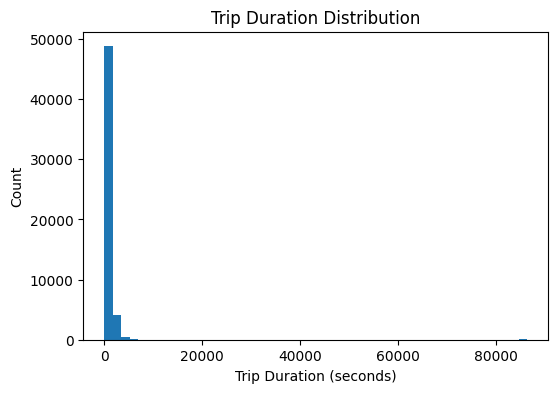

In [2]:
# Data Loading and Initial Sanity Check
# This cell loads the NYC taxi dataset, verifies that the data
# contains no missing values, and visualizes the raw distribution
# of trip duration to understand its shape.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("NYC.csv")

# Display dataset to confirm successful loading and inspect columns
print(df)


# Raw Trip Duration Distribution

# Visualize the distribution of trip duration (in seconds)
# This helps identify skewness and potential outliers
plt.figure(figsize=(6, 4))
plt.hist(df["trip_duration"], bins=50)
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Count")
plt.title("Trip Duration Distribution")
plt.show()


> Data set has no null values
when plotting the histogram above we see that there is only one big column on the left, which means the plot is heavily right skewed



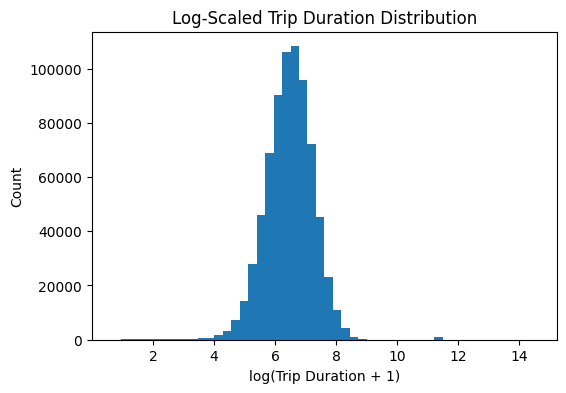

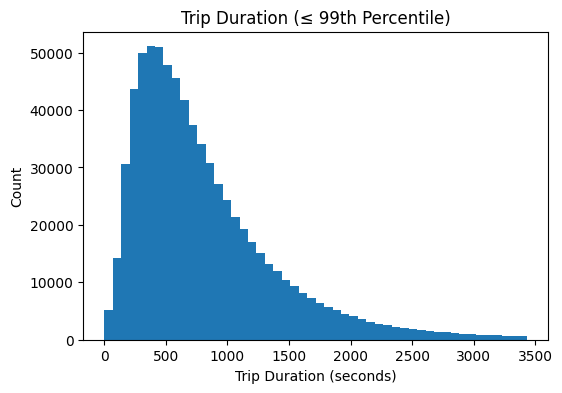

In [3]:

# Target Transformation and Outlier Inspection

# The raw trip duration distribution is heavily right-skewed.
# To stabilize variance and make linear modeling feasible,
# a log(1 + x) transformation is applied to the target variable.
# We also inspect the upper tail separately to understand
# the impact of extreme values.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reload dataset (kept explicit for notebook clarity)
df = pd.read_csv("NYC.csv")


# Log Transformation of Trip Duration


# Apply log transformation to reduce skewness
log_duration = np.log1p(df["trip_duration"])
df["log_duration"] = log_duration

# Visualize log-transformed distribution
plt.figure(figsize=(6, 4))
plt.hist(log_duration, bins=50)
plt.xlabel("log(Trip Duration + 1)")
plt.ylabel("Count")
plt.title("Log-Scaled Trip Duration Distribution")
plt.show()


# Upper-Tail Inspection (99th Percentile)


# Examine trip durations excluding extreme outliers
upper = df["trip_duration"].quantile(0.99)

plt.figure(figsize=(6, 4))
plt.hist(df[df["trip_duration"] <= upper]["trip_duration"], bins=50)
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Count")
plt.title("Trip Duration (≤ 99th Percentile)")
plt.show()


**Trip Duration Distribution (Raw Scale)**

* Trip duration is measured in seconds on a linear scale.

* The distribution is heavily right-skewed with a long tail of extreme values.

* A small number of very long trips stretch the x-axis, compressing most observations near zero.

> This scale reflects raw reality but is not suitable for parametric statistical analysis.



**Trip Duration Distribution (Log-Transformed)**

* Trip duration is transformed using a logarithmic scale (log(trip_duration + 1)).

* The distribution becomes approximately normal, with reduced skewness.

* The transformation compresses extreme values while preserving relative differences.

> Log-transformed duration is appropriate for hypothesis testing and regression.

In [4]:

# Feature Engineering: Trip Distance (Haversine Formula)

# Trip distance is not directly provided in the dataset.
# We compute the great-circle distance (in kilometers)
# between pickup and dropoff coordinates using the
# Haversine formula.

import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    """
    Compute great-circle distance between two points
    on the Earth specified by latitude and longitude.
    """
    R = 6371  # Earth radius in kilometers

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2) ** 2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

# Compute trip distance in kilometers
df["distance_km"] = haversine(
    df["pickup_latitude"],
    df["pickup_longitude"],
    df["dropoff_latitude"],
    df["dropoff_longitude"]
)

# Inspect computed distances
print(df["distance_km"])


0         1.498521
1         1.805507
2         6.385098
3         1.485498
4         1.188588
            ...   
731983    2.152577
731984    0.602044
731985    1.554362
731986    2.131603
731987         NaN
Name: distance_km, Length: 731988, dtype: float64


---

> Now we need to calculate the distance traveled of each trip, in order to implement **Correlation Analysis** on the dataset.

> For calculating the distance we are given Lattitudes and Longitudes of both, pick up and drop off.
knowing this we can use Haversin formula for calculating the distance



> written is the formula we are going to use.

$  d=2R \cdot arcsin(\sqrt {sin^2(2Δϕ/{2}​)+cos(ϕ1​)cos(ϕ2​)sin2(2Δλ/2​)}) $



Distance Calculation (Haversine Formula)

* Trip distance is calculated using pickup and dropoff latitude–longitude coordinates.

* The Haversine formula is used to compute the great-circle distance between two points on the Earth’s surface.

* This formula accounts for the curvature of the Earth, making it more accurate than simple Euclidean distance for geographic data.

*

* Distance is measured in kilometers, providing a physically meaningful feature.

---

**What This Achieves in the Analysis**

* Introduces a key explanatory variable strongly related to trip duration.

* Allows control for distance when:

* Performing correlation analysis

* Testing rush vs non-rush hypotheses

* Helps distinguish distance effects from traffic or time-of-day effects.

* Prevents misleading conclusions caused by ignoring spatial separation.

> **Adding Hour and Weekday columns into the dataset**

In [ ]:

# Feature Engineering: Temporal Features

# Extract time-based features from pickup timestamps.
# These features enable analysis of hourly and weekday
# patterns in trip duration and congestion effects.

import pandas as pd

# Convert pickup datetime to pandas datetime format
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

# Extract hour of day (0–23)
df["hour"] = df["pickup_datetime"].dt.hour

# Extract weekday as integer (Monday=0, Sunday=6)
df["weekday"] = df["pickup_datetime"].dt.weekday

# Extract weekday name (for interpretability and plotting)
df["weekday_name"] = df["pickup_datetime"].dt.day_name()


In [ ]:

# Exploratory Analysis: Spearman Correlation

# Compute Spearman rank correlations between key features
# and the log-transformed trip duration.
# Spearman correlation is used to capture monotonic
# relationships without assuming linearity.

import pandas as pd
import numpy as np

# Select features for correlation analysis
corr_features = [
    "log_duration",
    "distance_km",
    "passenger_count",
    "hour",
    "weekday"
]

# Compute Spearman correlation matrix
spearman_corr = df[corr_features].corr(method="spearman")

# Display correlation matrix
print(spearman_corr)


                 log_duration  distance_km  passenger_count      hour  \
log_duration         1.000000     0.794114         0.026348  0.031138   
distance_km          0.794114     1.000000         0.017833  0.006084   
passenger_count      0.026348     0.017833         1.000000  0.026817   
hour                 0.031138     0.006084         0.026817  1.000000   
weekday             -0.029963     0.026649         0.040201 -0.061428   

                  weekday  
log_duration    -0.029963  
distance_km      0.026649  
passenger_count  0.040201  
hour            -0.061428  
weekday          1.000000  


---

> log_duration and distance_km are ranked the highest in the corelation analysis

```
                 log_duration  distance_km  
log_duration         1.000000     0.794114  
distance_km          0.794114     1.000000
```



---
> Now finding out if 7–10 AM & 4–7 PM
are actually rush hours.

* We will count the number of trips that happened
in the rush hours
by applying a condition in a new column :
```
df["is_rush"] =
((df["hour"] >= 7 & df["hour"] < 10)|
(df["hour"] >= 16 & df["hour"] < 19))
```
> The constraint will consist of boolean values,
marking the individual trips duration in the
following category. If the trip happened in either
of the rush hours then it will be marked “True”
or else “False”.


---

In [ ]:

# Feature Engineering: Rush Hour Indicator

# Define a binary rush-hour feature based on common NYC
# peak traffic windows:
# - Morning rush: 7–10 AM
# - Evening rush: 4–7 PM
# This feature captures coarse congestion effects
# for use in regression modeling.

# Create rush-hour indicator
df["is_rush"] = (
    ((df["hour"] >= 7) & (df["hour"] < 10)) |
    ((df["hour"] >= 16) & (df["hour"] < 19))
).astype(int)

# Inspect class balance
df["is_rush"].value_counts(normalize=True)

# Validate hour distribution within rush vs non-rush periods
df.groupby("is_rush")["hour"].describe()


,count,mean,std,min,25%,50%,75%,max
is_rush,,,,,,,,
0,1036932.0,13.841222,6.993475,0.0,10.0,14.0,20.0,23.0
1,421712.0,13.029295,4.575270,7.0,8.0,16.0,17.0,18.0


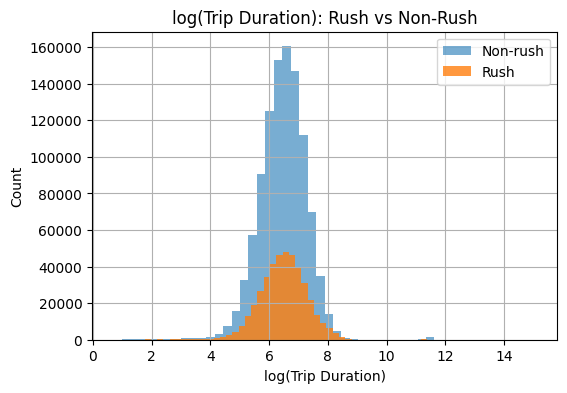

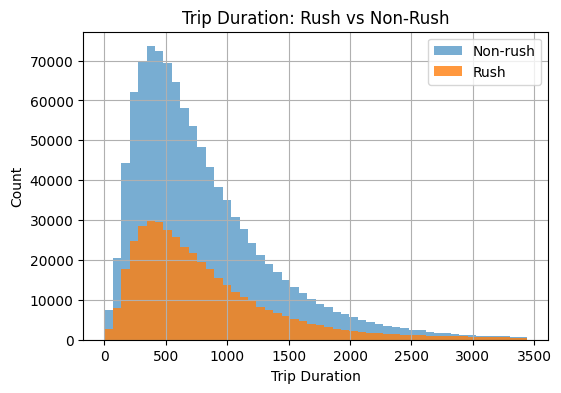

In [ ]:

# Exploratory Analysis: Rush vs Non-Rush Trip Duration
# Compare trip duration distributions between rush and
# non-rush periods to visually assess congestion effects.
# Both log-transformed and raw durations are examined.

import matplotlib.pyplot as plt

# Log-Transformed Duration Comparison
plt.figure(figsize=(6, 4))
df[df["is_rush"] == 0]["log_duration"].hist(
    bins=50, alpha=0.6, label="Non-rush"
)
df[df["is_rush"] == 1]["log_duration"].hist(
    bins=50, alpha=0.8, label="Rush"
)

plt.xlabel("log(Trip Duration)")
plt.ylabel("Count")
plt.legend()
plt.title("Log-Transformed Trip Duration: Rush vs Non-Rush")
plt.show()



# Raw Duration Comparison (≤ 99th Percentile)

# Limit extreme outliers to make distributions comparable
upper = df["trip_duration"].quantile(0.99)

plt.figure(figsize=(6, 4))
df[
    (df["is_rush"] == 0) &
    (df["trip_duration"] <= upper)
]["trip_duration"].hist(
    bins=50, alpha=0.6, label="Non-rush"
)

df[
    (df["is_rush"] == 1) &
    (df["trip_duration"] <= upper)
]["trip_duration"].hist(
    bins=50, alpha=0.8, label="Rush"
)

plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Count")
plt.legend()
plt.title("Trip Duration (≤ 99th Percentile): Rush vs Non-Rush")
plt.show()




> While log transformation reveals similar central tendencies between rush and non-rush trips, the raw scale highlights a heavier right tail during rush hours, indicating increased likelihood of extreme delays.


In [ ]:
# Summary statistics of log trip duration by rush vs non-rush
df.groupby("is_rush")["log_duration"].agg(
    count="count",
    mean="mean",
    median="median",
    std="std"
)



,count,mean,median,std
is_rush,,,,
0,1036932,6.459125,6.493754,0.791038
1,421712,6.486288,6.505784,0.806927


> Welch’s t-test was used instead of Student’s t-test because it does not assume equal variances between rush and non-rush groups, making it a more robust and appropriate choice for this dataset.

In [ ]:
# Welch’s t-test to compare log trip duration between rush and non-rush periods
from scipy.stats import ttest_ind

rush = df[df["is_rush"] == 1]["log_duration"]
non_rush = df[df["is_rush"] == 0]["log_duration"]

# Check variance to justify Welch’s t-test
print("rush vs non-rush variance:", rush.var(), non_rush.var())

# Two-sample Welch’s t-test
t_stat, p_value = ttest_ind(rush, non_rush, equal_var=False)
print(f"t-statistics: {t_stat}, p-value: {p_value}")

# Mean comparison
mean_rush = rush.mean()
mean_non_rush = non_rush.mean()
print(f"mean_rush: {mean_rush}, mean_non_rush: {mean_non_rush}")

# Convert log-mean difference to percentage change
log_diff = mean_rush - mean_non_rush
percent_change = (np.exp(log_diff) - 1) * 100
print("Percentage change:", percent_change)


rush vs non rush variance : 0.651131975370923 0.6257412121963167
t-statistics: 18.535849740074056  p-value:1.1027997232396823e-76 
mean_rush: 6.486288197910657,non mean rush: 6.459125271795944
Percentage change: 2.753520144441257


> A Welch’s two-sample t-test shows that rush-hour trips have significantly higher log-transformed durations than non-rush trips (t = 18.54, p ≪ 0.05). The estimated practical effect corresponds to an average increase of approximately 2.75% in trip duration during rush hours.

/tmp/ipython-input-3550373616.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


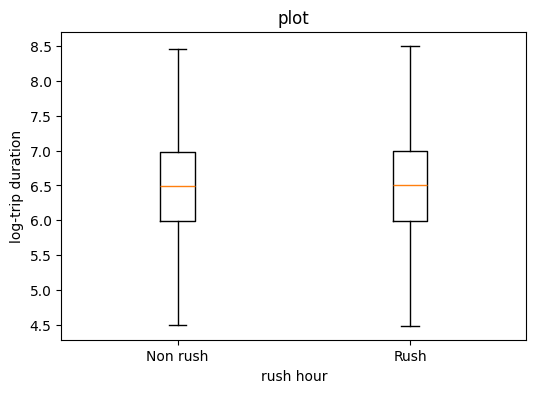

In [ ]:
# Boxplot comparison of log trip duration for rush vs non-rush periods
plt.figure(figsize=(6, 4))
plt.boxplot(
    [
        df[df["is_rush"] == 0]["log_duration"],
        df[df["is_rush"] == 1]["log_duration"]
    ],
    labels=["Non-rush", "Rush"],
    showfliers=False
)
plt.xlabel("Rush hour")
plt.ylabel("Log trip duration")
plt.title("Log Trip Duration: Rush vs Non-Rush")
plt.show()


> “Although the median difference appears modest, the consistent upward shift of the rush-hour distribution across the interquartile range aligns with the statistically significant difference observed in the Welch’s t-test, indicating a small but systematic increase in trip duration during peak traffic periods.”

In [ ]:
import numpy as np

# target
y = df["log_duration"].values

# baseline prediction: mean
y_pred_baseline = np.full_like(y, y.mean())

# errors
mae_baseline = np.mean(np.abs(y - y_pred_baseline))
rmse_baseline = np.sqrt(np.mean((y - y_pred_baseline) ** 2))

print(mae_baseline, rmse_baseline)

0.6054636388306619 0.7957592365411509


0.6054636388306619 0.7957592365411509

>“A constant baseline model that predicts the mean log-trip duration yields an MAE of X and an RMSE of Y. These values serve as a reference point for evaluating the effectiveness of subsequent regression models.”

In [ ]:
x = df["distance_km"].values
y = df["log_duration"].values

# solve for w and b
w = np.cov(x, y, bias=True)[0, 1] / np.var(x)
b = y.mean() - w * x.mean()

y_pred = w * x + b

# metrics
mae_lr = np.mean(np.abs(y - y_pred))
rmse_lr = np.sqrt(np.mean((y - y_pred) ** 2))

print(w, b, mae_lr, rmse_lr)

0.10623519170872286 6.101437573023655 0.455766897272661 0.6518375556276866


> If a taxi trip is x units long, the model predicts how long the trip will take on average, ignoring traffic, time of day, and everything else.

> The baseline linear regression predicts the expected log-trip duration as a linear function of trip distance, capturing the average relationship between distance and travel time while ignoring congestion and temporal effects.

>A baseline linear regression using trip distance as the sole predictor explains a substantial portion of trip duration, indicating that distance is the primary determinant of travel time, averaged across all traffic conditions.

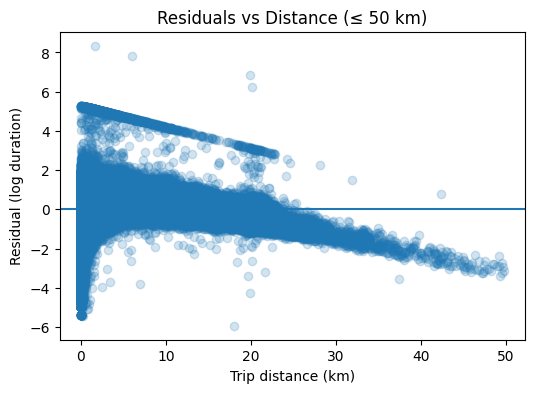

In [ ]:
#residuals vs distance

import matplotlib.pyplot as plt
x_dist = df["distance_km"].values
y_true = df["log_duration"].values

y_pred = w * x_dist + b
resd = y_true - y_pred
mask = x_dist <= 50

#Residual vs Distance (<=50 km)
plt.figure(figsize=(6,4))
plt.scatter(x_dist[mask], resd[mask], alpha=0.2)
plt.axhline(0)
plt.xlabel("Trip distance (km)")
plt.ylabel("Residual (log duration)")
plt.title("Residuals vs Distance (≤ 50 km)")
plt.show()



##**Baseline Linear Regression and Residual Analysis**

A baseline linear regression model of the form

$ log(trip duration)=𝑤⋅distance+𝑏 $

> was fitted to estimate the relationship between trip distance and trip duration. The model was trained using log-transformed trip duration to account for the strong right-skew observed in the raw duration distribution.

The estimated parameters were:

$ 𝑤 =0.106 $

> $ w=0.106 $, indicating that each additional kilometer increases expected trip duration by approximately 11% on average

$ 𝑏 = 6.10 $

> $ b=6.10 $ , representing baseline travel time independent of distance

**Model evaluation yielded an MAE of 0.456 and an RMSE of 0.652, demonstrating a clear improvement over a constant mean baseline and confirming that trip distance explains a substantial portion of trip duration.**
> * Residual analysis was conducted to assess the baseline distance-only regression model.
> * Extreme long-distance trips were present; therefore, residuals were examined for trips with distance ≤ 50 km to avoid scale distortion.
> * The residual plot shows systematic structure rather than random scatter.
> * The model underpredicts short trips and overpredicts longer trips, indicating that a single linear distance–duration relationship is insufficient.
> * Residual variance is higher for short trips, suggesting heteroscedasticity driven by unmodeled traffic and temporal effects.
> * These findings motivate the inclusion of congestion-related features, such as a rush-hour indicator, in subsequent models.

> **How long does a NYC taxi trip take, and how does distance and rush hour affect it?**

b, w1, w2 : 5.272445759269805 0.9309922141652166 -0.014247632502214396 0.08793640048342619
mae_lr2, rmse_lr2 : 0.3713945154866289 0.5241782372344124
-2.223673255905543e-15


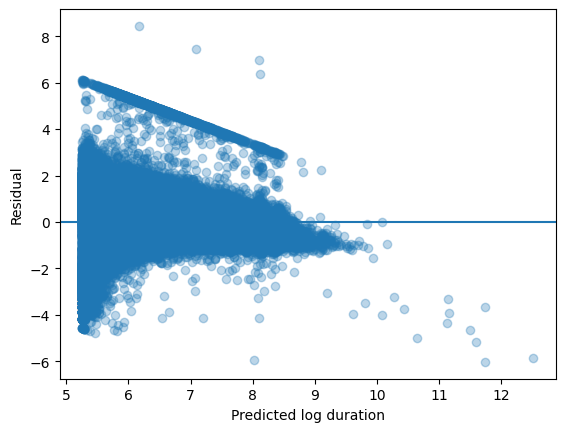

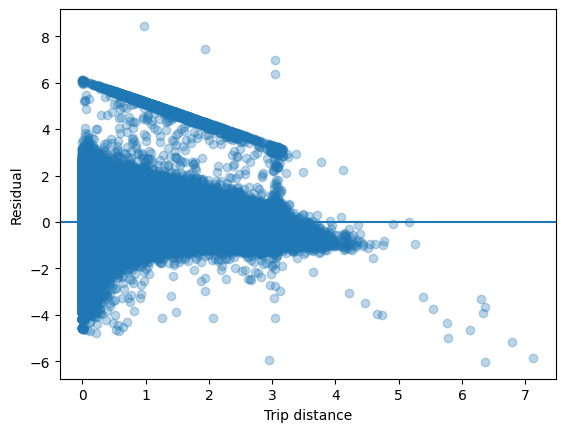

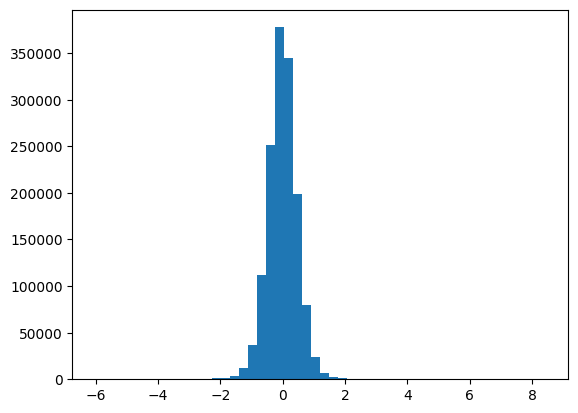

In [ ]:

# Feature Preparation


# Log-transform distance to capture diminishing returns
x_dist = np.log1p(df["distance_km"].values)

# Binary indicator for rush hour
x_rush = df["is_rush"].values

# Interaction term: distance effect during rush hour
x_interact = x_dist * x_rush

# Target variable: log-transformed trip duration
y = df["log_duration"].values



# Design Matrix Construction

# Stack features into a design matrix:
# [1, log(distance), is_rush, log(distance) × is_rush]
X = np.column_stack([
    np.ones(len(x_dist)),   # Intercept term
    x_dist,                 # Distance effect
    x_rush,                 # Rush hour effect
    x_interact              # Interaction effect
])


# Model Estimation (Normal Equation)


# Estimate regression coefficients using OLS normal equation
beta = np.linalg.inv(X.T @ X) @ X.T @ y

# Unpack coefficients
b, w1, w2, w3 = beta

print("Intercept (b):", b)
print("Distance coefficient (w1):", w1)
print("Rush hour coefficient (w2):", w2)
print("Interaction coefficient (w3):", w3)



# Predictions and Error Metrics

# Generate predictions
y_pred = X @ beta

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(y - y_pred))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((y - y_pred) ** 2))

print("MAE:", mae)
print("RMSE:", rmse)



# Residual Analysis

# Compute residuals
residuals = y - y_pred

# Mean of residuals (should be ~0 for OLS)
print("Mean residual:", residuals.mean())


# Diagnostic Plots

# Residuals vs predicted values
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0)
plt.xlabel("Predicted log trip duration")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted Values")
plt.show()

# Residuals vs distance
plt.scatter(x_dist, residuals, alpha=0.3)
plt.axhline(0)
plt.xlabel("Log-transformed trip distance")
plt.ylabel("Residual")
plt.title("Residuals vs Distance")
plt.show()

# Residual distribution
plt.hist(residuals, bins=50)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()


**Interaction-Based Linear Regression and Residual Diagnostics**

In this section, we build an interpretable linear regression model to estimate the average log-transformed trip duration using distance, rush hour, and their interaction.

The model uses:

* ``` log1p(distance_km) ``` to capture diminishing returns of distance on trip time

* ``` is_rush ``` as a binary indicator of rush hour

* an interaction term to allow the effect of distance to differ between rush and non-rush periods

The regression coefficients are estimated explicitly using the normal equation, avoiding external libraries to keep the mechanics transparent.

Model performance is evaluated using **MAE** and **RMSE** on the log scale.
Residuals are then analyzed through:

* residuals vs predicted values (to check model bias and variance structure)

* residuals vs distance (to detect heteroscedasticity)

* a residual histogram (to assess error distribution)

> These diagnostics are used to assess whether a mean-based linear model is sufficient and to highlight structural limitations such as non-constant variance and asymmetric errors.